# Data Mining Final Project 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics import silhouette_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Crime Dataset 

In [2]:
# Load the dataset
train = pd.read_csv('train.csv')
train.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Dates       878049 non-null  object 
 1   Category    878049 non-null  object 
 2   Descript    878049 non-null  object 
 3   DayOfWeek   878049 non-null  object 
 4   PdDistrict  878049 non-null  object 
 5   Resolution  878049 non-null  object 
 6   Address     878049 non-null  object 
 7   X           878049 non-null  float64
 8   Y           878049 non-null  float64
dtypes: float64(2), object(7)
memory usage: 60.3+ MB


# Data Preprocessing

## Cleaning Data 

In [4]:
# checking if there is null values 
train.isnull().sum()

Dates         0
Category      0
Descript      0
DayOfWeek     0
PdDistrict    0
Resolution    0
Address       0
X             0
Y             0
dtype: int64

In [5]:
columns_to_drop = ['Descript', 'Resolution', 'Address']
# Drop the unwanted features
train.drop(columns=[col for col in columns_to_drop if col in train.columns], inplace=True)

In [6]:
# check for duplicated
print(train.duplicated().sum())

65576


In [7]:
# drop duplicates
train.drop_duplicates(inplace=True)

In [8]:
print(train.duplicated().sum())

0


In [9]:
# Check for data types to make encoding
train.dtypes

Dates          object
Category       object
DayOfWeek      object
PdDistrict     object
X             float64
Y             float64
dtype: object

In [10]:
# Extracts useful datetime features (hour, month, day of week) from the 'Dates' column and removes the original column
train['Dates'] = pd.to_datetime(train['Dates'])
train['Hour'] = train['Dates'].dt.hour
train['Month'] = train['Dates'].dt.month
train['DayOfWeek'] = train['Dates'].dt.dayofweek  # 0 = Monday
train = train.drop(columns='Dates')

In [11]:
# Encode categorical columns ('Category' and 'PdDistrict') into numeric labels using LabelEncoder
le = LabelEncoder()
train['Category'] = le.fit_transform(train['Category'])
train['PdDistrict'] = le.fit_transform(train['PdDistrict'])

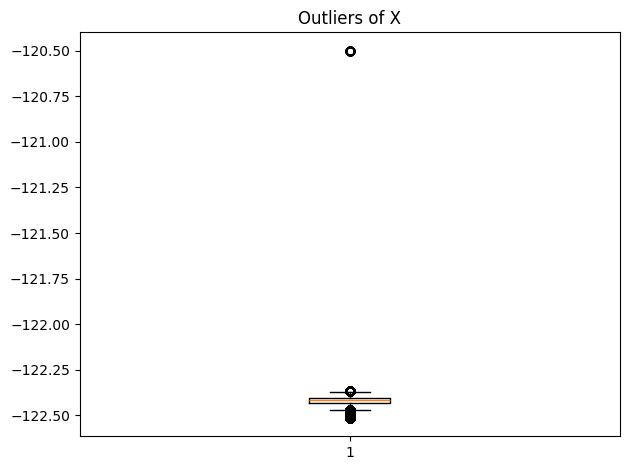

In [12]:
# check for outliers in x 
plt.boxplot(x=train['X'])
plt.title("Outliers of X")
plt.tight_layout()
plt.show()

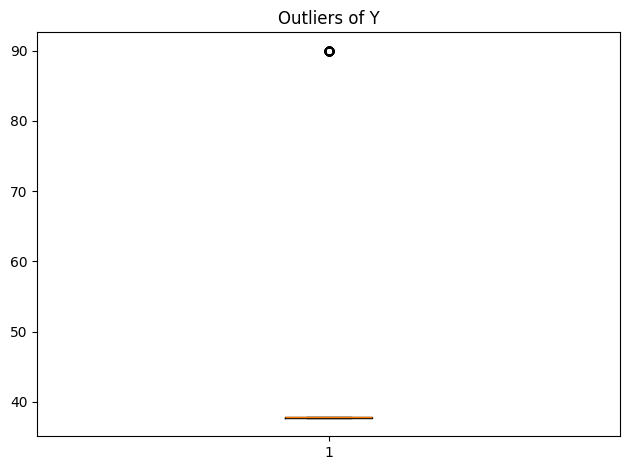

In [13]:
# check for outliers in y
plt.boxplot(x=train['Y'])
plt.title("Outliers of Y")
plt.tight_layout()
plt.show()

In [14]:
# calculate quantiles
Q1_X = train['X'].quantile(0.25)
Q3_X = train['X'].quantile(0.75)
IQR_X = Q3_X - Q1_X
lower_X = Q1_X - 1.5 * IQR_X
upper_X = Q3_X + 1.5 * IQR_X

# For 'Y'
Q1_Y = train['Y'].quantile(0.25)
Q3_Y = train['Y'].quantile(0.75)
IQR_Y = Q3_Y - Q1_Y
lower_Y = Q1_Y - 1.5 * IQR_Y
upper_Y = Q3_Y + 1.5 * IQR_Y

# Remove outliers in both columns
train = train[
    (train['X'] >= lower_X) & (train['X'] <= upper_X) &
    (train['Y'] >= lower_Y) & (train['Y'] <= upper_Y) 
]


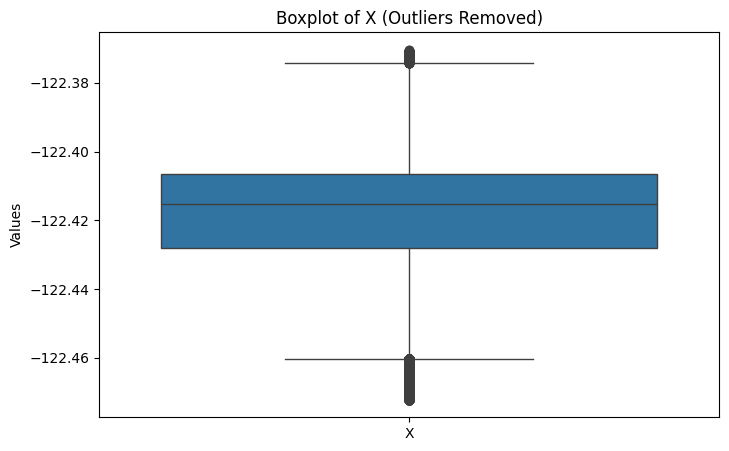

In [15]:
# plot to be sure there is no outliers
plt.figure(figsize=(8, 5))
sns.boxplot(data=train[['X']])
plt.title("Boxplot of X (Outliers Removed)")
plt.ylabel("Values")
plt.show()

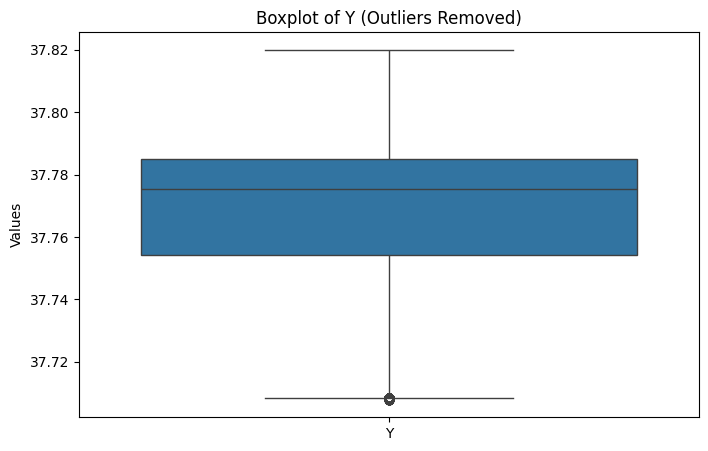

In [16]:
# plot to be sure there is no outliers
plt.figure(figsize=(8, 5))
sns.boxplot(data=train[['Y']])
plt.title("Boxplot of Y (Outliers Removed)")
plt.ylabel("Values")
plt.show()

In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 756887 entries, 0 to 878048
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Category    756887 non-null  int64  
 1   DayOfWeek   756887 non-null  int32  
 2   PdDistrict  756887 non-null  int64  
 3   X           756887 non-null  float64
 4   Y           756887 non-null  float64
 5   Hour        756887 non-null  int32  
 6   Month       756887 non-null  int32  
dtypes: float64(2), int32(3), int64(2)
memory usage: 37.5 MB


In [18]:
train.head(10)

,Category,DayOfWeek,PdDistrict,X,Y,Hour,Month
0,37,2,4,-122.425892,37.774599,23,5
1,21,2,4,-122.425892,37.774599,23,5
2,21,2,4,-122.424363,37.800414,23,5
3,16,2,4,-122.426995,37.800873,23,5
4,16,2,5,-122.438738,37.771541,23,5
5,16,2,2,-122.403252,37.713431,23,5
6,36,2,2,-122.423327,37.725138,23,5
7,36,2,0,-122.371274,37.727564,23,5
9,16,2,1,-122.419088,37.807802,23,5
10,16,2,1,-122.419088,37.807802,22,5


In [19]:
# describe dataset
train.describe()

,Category,DayOfWeek,PdDistrict,X,Y,Hour,Month
count,756887.000000,756887.000000,756887.000000,756887.000000,756887.000000,756887.000000,756887.000000
mean,19.316775,2.997416,4.219475,-122.418248,37.768047,13.388375,6.437035
std,10.516647,1.972001,2.828255,0.018678,0.024060,6.559123,3.427946
min,0.000000,0.000000,0.000000,-122.472265,37.707879,0.000000,1.000000
25%,16.000000,1.000000,2.000000,-122.428007,37.754337,9.000000,3.000000
50%,20.000000,3.000000,4.000000,-122.415128,37.775421,14.000000,6.000000
75%,25.000000,5.000000,7.000000,-122.406488,37.784914,19.000000,9.000000
max,38.000000,6.000000,9.000000,-122.370355,37.819975,23.000000,12.000000


In [20]:
# Take a fixed number of random rows
train_sample = train.sample(n=15000, random_state=42) 
train_sample = train_sample.reset_index(drop=True)
train_sample.head()

,Category,DayOfWeek,PdDistrict,X,Y,Hour,Month
0,16,4,5,-122.446144,37.770053,19,2
1,16,1,0,-122.401192,37.761643,18,9
2,16,6,6,-122.471762,37.773137,15,11
3,1,2,3,-122.431870,37.762739,13,5
4,1,6,9,-122.414312,37.779834,7,5


In [21]:
# choosing important features to use 
features = train_sample[['Category', 'PdDistrict', 'X', 'Y', 'Hour', 'DayOfWeek']]

## Normalization 

In [22]:
# Copy the original features DataFrame
features_scaled = features.copy()

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform only 'X' and 'Y' columns
features_scaled[['X', 'Y']] = scaler.fit_transform(features[['X', 'Y']])
features_scaled.head()

,Category,PdDistrict,X,Y,Hour,DayOfWeek
0,16,5,-1.475616,0.081019,19,4
1,16,0,0.919082,-0.267320,18,1
2,16,6,-2.840387,0.208773,15,6
3,1,3,-0.715217,-0.221933,13,2
4,1,9,0.220129,0.486158,7,6


# Mining Techniques 

## Hierarchial Clustering

In [23]:
linked = linkage(features_scaled, method='ward')
k =5
cluster_labels = fcluster(linked, t=k, criterion='maxclust')
# put cluster feature in train_sample dataframe
train_sample['Cluster'] = cluster_labels

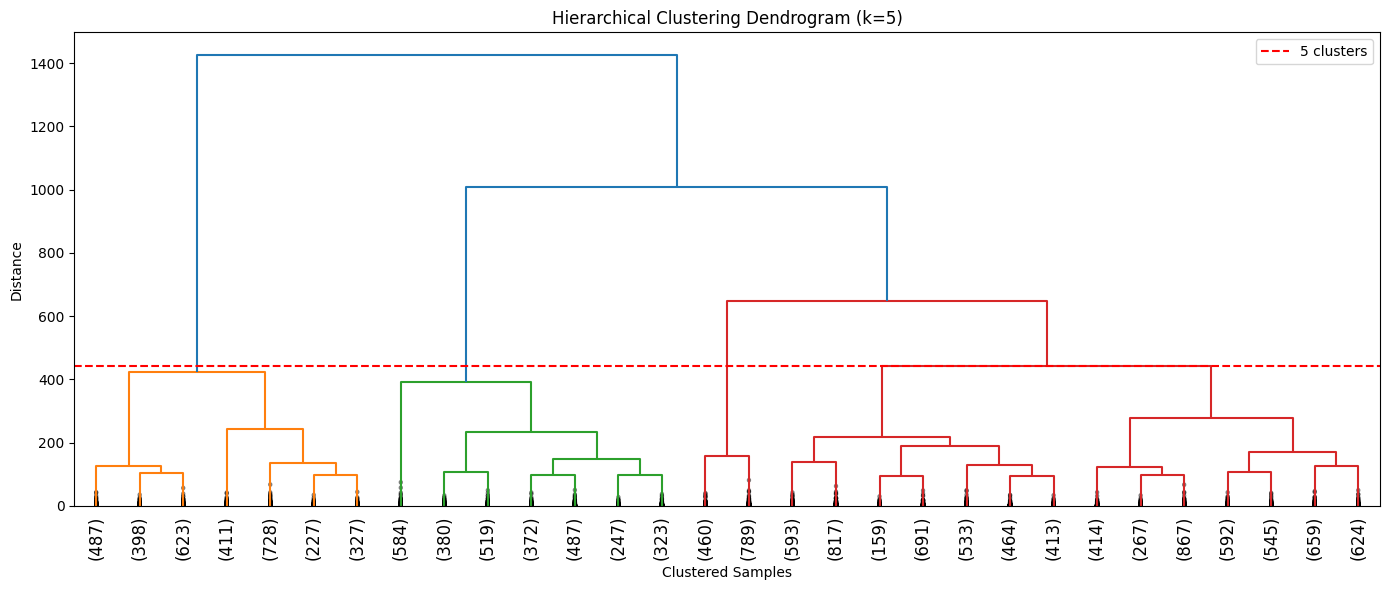

In [24]:
# plot the hieararchial clustering by dendrogram
plt.figure(figsize=(14, 6))
dendrogram(
    linked,
    truncate_mode='lastp',
    p=30,
    show_leaf_counts=True,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
)
plt.axhline(y=linked[-(k - 1), 2], c='red', linestyle='--', label=f'{k} clusters')
plt.title(f'Hierarchical Clustering Dendrogram (k={k})')
plt.xlabel('Clustered Samples')
plt.ylabel('Distance')
plt.legend()
plt.tight_layout()
plt.show()


## KNN

In [25]:
# make copy of features dataframe 
X = features.copy()
# use cluster of hierarchial as y in knn
y = train_sample['Cluster']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Initialize the scaler
scaler = StandardScaler()
# Isolate 'X' and 'Y' columns from X_train for scaling
X_train_scaled_xy = scaler.fit_transform(X_train[['X', 'Y']])

# Replace the original 'X' and 'Y' columns in X_train with the scaled values
X_train[['X', 'Y']] = X_train_scaled_xy

# Check the resulting X_train
X_train.head()


,Category,PdDistrict,X,Y,Hour,DayOfWeek
11797,4,0,1.423534,-1.901537,18,4
5899,16,1,0.386763,0.858924,1,6
9513,20,7,0.796057,0.302666,14,6
1572,1,9,0.314914,0.616634,1,1
12995,16,7,0.515489,0.602533,16,4


In [27]:
# Initialize and train KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


# Evaluation Metric

In [28]:
# Calculate the Silhouette Score for Hierarchial Clustering
X = train_sample.drop(['Cluster'],axis=1)
hierarchical_score = silhouette_score(X, train_sample['Cluster'])
print(f"Silhouette Score for Hierarchical Clustering: {hierarchical_score:.3f}")

Silhouette Score for Hierarchical Clustering: 0.258


In [29]:
# Make predictions
y_pred = knn.predict(X_test)
# Evaluate Knn by accuracy 
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.8426666666666667


# Visualization

C:\Users\farah\AppData\Local\Temp\ipykernel_16568\3953960492.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis')


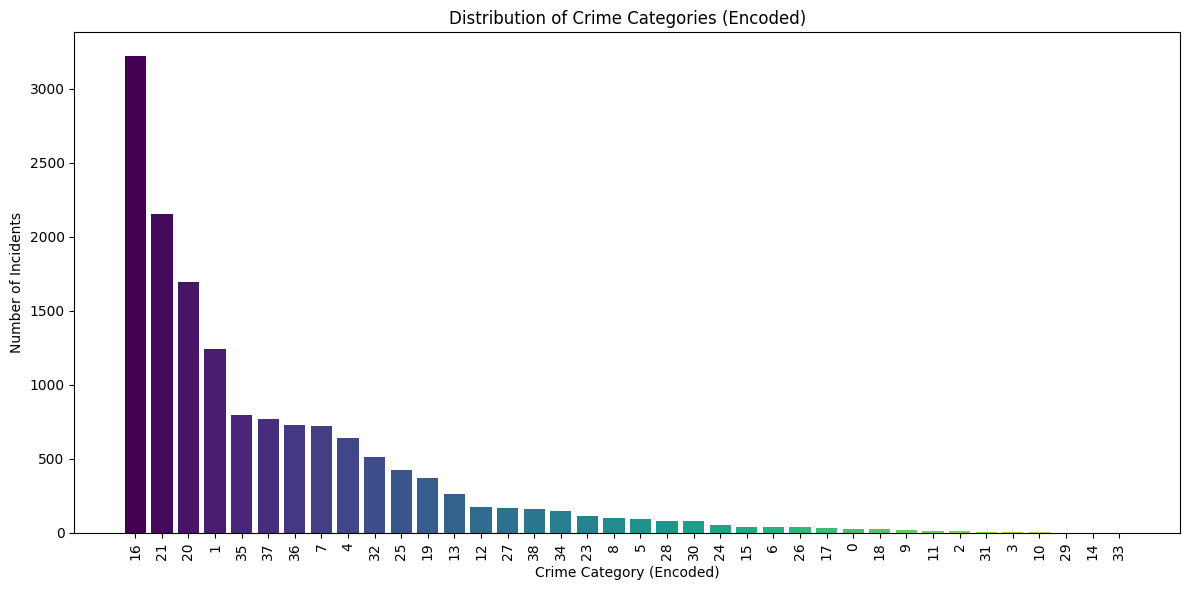

In [30]:
# Count the encoded categories in descending order
category_counts = train_sample['Category'].value_counts().sort_values(ascending=False)

# Generate colors using the viridis colormap
cmap = plt.cm.get_cmap('viridis')
colors = cmap([i / len(category_counts) for i in range(len(category_counts))])

# Create the bar plot
plt.figure(figsize=(12, 6))
plt.bar(category_counts.index.astype(str), category_counts.values, color=colors)

plt.title('Distribution of Crime Categories (Encoded)')
plt.xlabel('Crime Category (Encoded)')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

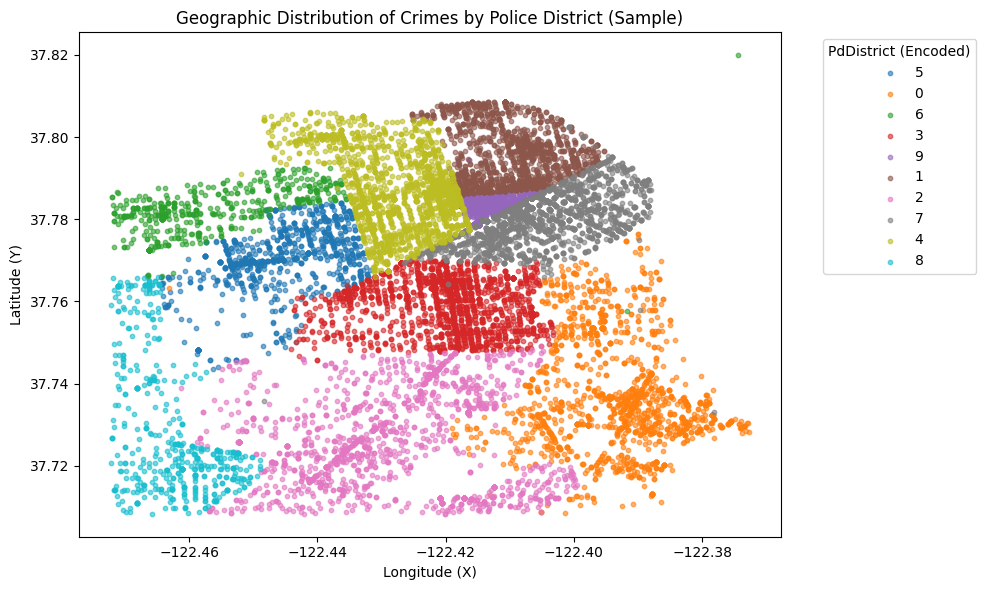

In [31]:
# Get unique police districts and assign colors
districts = train_sample['PdDistrict'].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(districts)))

plt.figure(figsize=(10, 6))

# Plot each district's points separately
for color, district in zip(colors, districts):
    subset = train_sample[train_sample['PdDistrict'] == district]
    plt.scatter(
        subset['X'], subset['Y'],
        s=10, alpha=0.6,
        label=district, color=color
    )

plt.title('Geographic Distribution of Crimes by Police District (Sample)')
plt.xlabel('Longitude (X)')
plt.ylabel('Latitude (Y)')
plt.legend(title='PdDistrict (Encoded)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

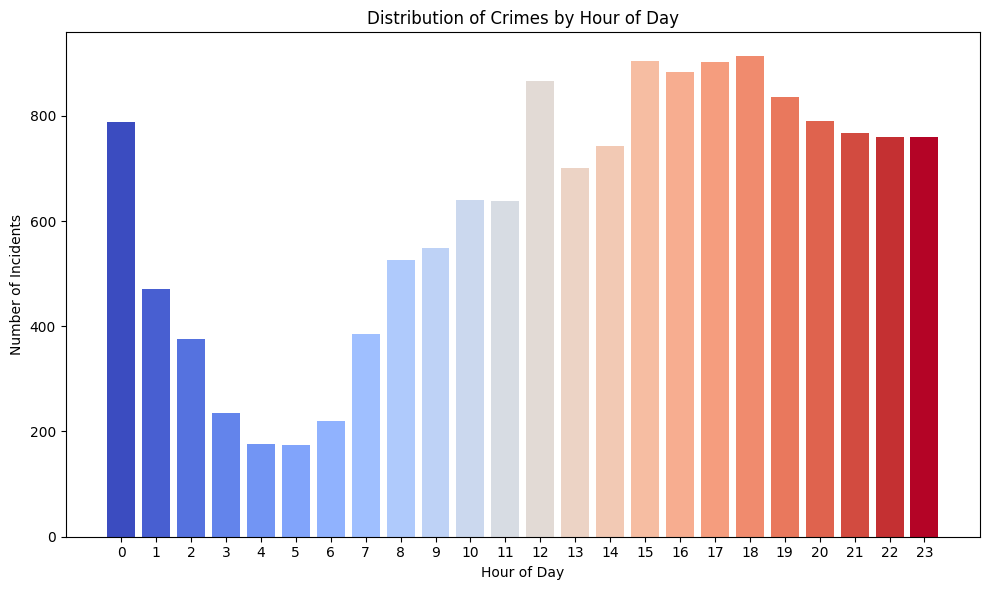

In [32]:
# Count the number of incidents for each hour
hour_counts = train_sample['Hour'].value_counts().sort_index()
hours = hour_counts.index
counts = hour_counts.values

# Create the bar plot
plt.figure(figsize=(10, 6))
colors = plt.cm.coolwarm((hours - min(hours)) / (max(hours) - min(hours)))  # Normalize hours for colormap
plt.bar(hours, counts, color=colors)

plt.title('Distribution of Crimes by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Incidents')
plt.xticks(hours)  # Ensure all hours appear on the x-axis
plt.tight_layout()
plt.show()